## Yield Spread Model 


This notebook implements the model to predict the yield spread using the reference data and trade history

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from google.cloud import bigquery
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from datetime import datetime
import matplotlib.pyplot as plt
import pickle5 as pickle
from lightgbm import LGBMRegressor
import lightgbm
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch, Hyperband, BayesianOptimization
from IPython.display import display, HTML
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


from data_preparation import process_data
# from numerical_embedding import NumericalEmbedding

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Setting the seed for layer initializer. We want the layers to be initialized with the same values in all the experiments to remove randomness from the results

In [2]:
layer_initializer = initializers.RandomNormal(mean=0.0, stddev=0.1, seed=10)

Setting up the credentials for GCP

In [3]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="eng-reactor-287421-112eb767e1b3.json"

In [4]:
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'

Initializing the big query client

In [5]:
bq_client = bigquery.Client()

Checking if GPU is available

In [6]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

#### Hyper-parameters for the model

The batch size and learning rate have an impact on the smoothness of convergence of the model.\
Larger the batch size the smoother the convergence. For a larger batch size we need a higher learning rate and vice-versa

In [7]:
TRAIN_TEST_SPLIT = 0.85
LEARNING_RATE = 0.0001
BATCH_SIZE = 1000
NUM_EPOCHS = 100

SEQUENCE_LENGTH = 5
NUM_FEATURES = 5


### Query to fetch data from BigQuery

The SQL query uses the trade history for the training data view. All three trade directions, namely dealer-dealer (D), dealer-sells (S), and dealer-purchases (P) are included. We are limiting the training to bonds whose yield is a positive number less than three.  


In [8]:
DATA_QUERY = """ SELECT
  *
FROM
  `eng-reactor-287421.primary_views.trade_history_for_training_no_neg_yields` 
WHERE
  yield IS NOT NULL
  AND yield > 0 
  AND yield <= 3 
  AND par_traded IS NOT NULL
  AND sp_long IS NOT NULL
  AND trade_date >= '2021-07-01' 
  AND trade_date <= '2021-10-01'
  AND msrb_valid_to_date > current_date -- condition to remove cancelled trades
ORDER BY
  trade_date DESC
            """

### Data Preparation

We grab the data from BigQuery and converts it into a format suitable for input to the model. The fetch_data function uses the big query functionality to return the data from the SQL query as a dataframe. 

In [9]:
processed_file = 'tuning.pkl'

In [12]:
%%time
if not os.path.isfile(processed_file):
    reference_data = process_data(DATA_QUERY, 
                              bq_client,
                              SEQUENCE_LENGTH,
                              NUM_FEATURES,
                              'data.pkl')
    reference_data.to_pickle(processed_file)
else:
    print('Reading from processed file')
    reference_data = pd.read_pickle(processed_file)

Fetching data
Reading from file
File read
Dropping empty trades
Dropping trades less that 10000$
Creating trade history
Trade history created
Data fetched
Padding history
Padding completed
Length before removing Nulls:671175
Length after removing Nulls:652978
Number of samples 652978
CPU times: user 3min 59s, sys: 1min 24s, total: 5min 24s
Wall time: 5min 43s


In [13]:
df = reference_data.copy()

Dropping columns that we do not use as features to train the model. These features were dropped after analyzing their importance using LightGBM

In [14]:
def drop_extra_columns(df):
    df.drop(columns=[
                 'sp_stand_alone',
                 'sp_icr_school',
                 'sp_icr_school',
                 'sp_icr_school',
                 'sp_watch_long',
                 'sp_outlook_long',
                 'sp_prelim_long',
                 'MSRB_maturity_date',
                 'MSRB_INST_ORDR_DESC',
                 'MSRB_valid_from_date',
                 'MSRB_valid_to_date',
                 'upload_date',
                 'sequence_number',
                 'security_description',
                 'ref_valid_from_date',
                 'ref_valid_to_date',
                 'additional_next_sink_date',
                 'first_coupon_date',
                 'last_period_accrues_from_date',
                 'primary_market_settlement_date',
                 'assumed_settlement_date',
                 'sale_date','q','d'],
                  inplace=True)
    
    
    return df

In [15]:
%%time
df = drop_extra_columns(df)

CPU times: user 536 ms, sys: 112 ms, total: 648 ms
Wall time: 653 ms


We use the dictionary to map the interest payment frequency code. The dictionary is used to create a categorical feature used to train the model

In [16]:
COUPON_FREQUENCY_DICT = {0:"Unknown",
                        1:"Semiannually",
                        2:"Monthly",
                        3:"Annually",
                        4:"Weekly",
                        5:"Quarterly",
                        6:"Every 2 years",
                        7:"Every 3 years",
                        8:"Every 4 years",
                        9:"Every 5 years",
                        10:"Every 7 years",
                        11:"Every 8 years",
                        12:"Biweekly",
                        13:"Changeable",
                        14:"Daily",
                        15:"Term mode",
                        16:"Interest at maturity",
                        17:"Bimonthly",
                        18:"Every 13 weeks",
                        19:"Irregular",
                        20:"Every 28 days",
                        21:"Every 35 days",
                        22:"Every 26 weeks",
                        23:"Not Applicable",
                        24:"Tied to prime",
                        25:"One time",
                        26:"Every 10 years",
                        27:"Frequency to be determined",
                        28:"Mandatory put",
                        29:"Every 52 weeks",
                        30:"When interest adjusts-commercial paper",
                        31:"Zero coupon",
                        32:"Certain years only",
                        33:"Under certain circumstances",
                        34:"Every 15 years",
                        35:"Custom",
                        36:"Single Interest Payment"
                        }

Converting date objects returned from BigQuery into python datetime objects

In [17]:
def convert_dates(df):
    date_cols = [col for col in list(df.columns) if 'DATE' in col.upper()]
    for col in date_cols:
        df[col] = pd.to_datetime(df[col])
    
    return df

In [18]:
%%time
df = convert_dates(df)

CPU times: user 6.66 s, sys: 997 ms, total: 7.65 s
Wall time: 7.76 s


Currently we only support bond which are rated higher than AA- or bonds which do not have a rating.

In [19]:
def process_ratings(df):
    df = df[df.sp_long.isin(['A-','A','A+','AA-','AA','AA+','AAA','NR'])] 
    df['rating'] = df['sp_long']
    return df

In [20]:
%%time
df = process_ratings(df)

CPU times: user 558 ms, sys: 217 ms, total: 775 ms
Wall time: 784 ms


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


We pass a few features from the most recent trades to the referecne data model. Since the positions of these features are fixed we use indexing to extract them.

In [21]:
def get_latest_trade_feature(x, feature):
    recent_trade = x[0]
    if feature == 'yield_spread':
        return recent_trade[0]
    elif feature == 'seconds_ago':
        return recent_trade[-1]
    elif feature == 'par_traded':
        return recent_trade[1]

In [22]:
def process_features(df):
    global COUPON_FREQUENCY_DICT
    df.interest_payment_frequency.fillna(0, inplace=True)
    df.loc[:,'interest_payment_frequency'] = df.interest_payment_frequency.apply(lambda x: COUPON_FREQUENCY_DICT[x])
    
    df.loc[:,'quantity'] = np.log10(df.par_traded.astype(np.float32))
    df.coupon = df.coupon.astype(np.float32)
    df.issue_amount = np.log10(df.issue_amount.astype(np.float32))
    df['yield_spread'] = df['yield_spread'] * 100
    
    # Creating Binary features
    df.loc[:,'callable'] = df.is_callable  
    df.loc[:,'called'] = df.is_called 
    df.loc[:,'zerocoupon'] = df.coupon == 0
    df.loc[:,'whenissued'] = df.delivery_date >= df.trade_date
    df.loc[:,'sinking'] = ~df.next_sink_date.isnull()
    df.loc[:,'deferred'] = (df.interest_payment_frequency == 'Unknown') | df.zerocoupon
    
    # Converting the dates to a number of days from the settlement date. 
    # We only consider trades to be reportedly correctly if the trades are settled within one month of the trade date. 
    df.loc[:,'days_to_settle'] = (df.settlement_date - df.trade_date).dt.days.fillna(0)
    df = df[df.days_to_settle <= 31]

    df.loc[:, 'days_to_maturity'] =  np.log10(1 + (df.maturity_date - df.settlement_date).dt.days.fillna(0))
    df.loc[:, 'days_to_call'] = np.log10(1 + (df.next_call_date - df.settlement_date).dt.days.fillna(0))
    df.loc[:, 'days_to_refund'] = np.log10(1 + (df.refund_date - df.settlement_date).dt.days.fillna(0))
    df.loc[:, 'days_to_par'] = np.log10(1 + (df.par_call_date - df.settlement_date).dt.days.fillna(0))
    df.loc[:, 'call_to_maturity'] = np.log10(1 + (df.maturity_date - df.next_call_date).dt.days.fillna(0))
    
    # Removing bonds from Puerto Rico
    df = df[df.incorporated_state_code != 'PR']
    
    df.loc[:, 'last_seconds_ago'] = df.trade_history.apply(get_latest_trade_feature, args=["seconds_ago"])
    df.loc[:, 'last_yield_spread'] = df.trade_history.apply(get_latest_trade_feature, args=["yield_spread"])
    df.loc[:, 'last_size'] = df.trade_history.apply(get_latest_trade_feature, args=["par_traded"])


    df.maturity_amount = np.log10(1.0 + df.maturity_amount.astype(float))
    df.orig_principal_amount = np.log10(1.0 + df.orig_principal_amount.astype(float))
    df.max_amount_outstanding = np.log10(1.0 + df.max_amount_outstanding.astype(float))
    
    return df

In [23]:
%%time
df = process_features(df)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


CPU times: user 5.41 s, sys: 607 ms, total: 6.02 s
Wall time: 6.09 s


Filling missing values for categorical features. The missing values are filled by ther logical counterparts from the [47 Data Enumerations by XPath google sheet](https://docs.google.com/spreadsheets/d/1dV9fxeiWYuxpBs45mJUyRyybhDUbaZKoDEfHCBu6-WA/edit#gid=471190191).



In [24]:
def fill_missing_values(df):
    df.dropna(subset=['instrument_primary_name'], inplace=True)
    df.purpose_sub_class.fillna(1,inplace=True)
    df.call_timing.fillna(0, inplace=True) #Unknown
    df.call_timing_in_part.fillna(0, inplace=True) #Unknown
    df.sink_frequency.fillna(10, inplace=True) #Under special circumstances
    df.sink_amount_type.fillna(0, inplace=True)
    df.issue_text.fillna('No issue text', inplace=True)
    df.state_tax_status.fillna(0, inplace=True)
    df.series_name.fillna('No series name', inplace=True)

    df.next_call_price.fillna(100, inplace=True)
    df.par_call_price.fillna(100, inplace=True)
    df.min_amount_outstanding.fillna(0, inplace=True)
    df.max_amount_outstanding.fillna(0, inplace=True)
    # df.call_to_maturity.fillna(0, inplace=True)
    df.days_to_par.fillna(0, inplace=True)
    df.maturity_amount.fillna(0, inplace=True)
    df.issue_price.fillna(df.issue_price.mean(), inplace=True)
    df.orig_principal_amount.fillna(df.orig_principal_amount.mean(), inplace=True)
    df.original_yield.fillna(0, inplace=True)
    df.par_price.fillna(100, inplace=True)
    df.called_redemption_type.fillna(0, inplace=True)

    df.extraordinary_make_whole_call.fillna(False, inplace=True)
    df.make_whole_call.fillna(False, inplace=True)
    df.default_indicator.fillna(False, inplace=True)
    df.called_redemption_type.fillna(0, inplace=True)
    
    return df

In [25]:
df = fill_missing_values(df)

We train the model on a subset of features. These features are defined below

In [26]:
IDENTIFIERS = ['rtrs_control_number', 'cusip']


BINARY = ['callable',
          'sinking',
          'zerocoupon',
          'is_non_transaction_based_compensation',
          'is_general_obligation',
          'callable_at_cav',           
          'extraordinary_make_whole_call', 
          'make_whole_call',
          'has_unexpired_lines_of_credit',
          'escrow_exists',
          ]

CATEGORICAL_FEATURES = ['rating',
                        'incorporated_state_code',
                        'trade_type',
                        'transaction_type',
                        'maturity_description_code',
                        'purpose_class']

NON_CAT_FEATURES = ['quantity',
                    'days_to_maturity',
                    'days_to_call',
                    'coupon',
                    'issue_amount',
                    'last_seconds_ago',
                    'last_yield_spread',
                    'days_to_settle',
                    'days_to_par',
                    'maturity_amount',
                    'issue_price', 
                    'orig_principal_amount',
                    'max_amount_outstanding']

TRADE_HISTORY = ['trade_history']
TARGET = ['yield_spread']

PREDICTORS = BINARY + CATEGORICAL_FEATURES + NON_CAT_FEATURES + TARGET + TRADE_HISTORY

In [27]:
processed_data = df[IDENTIFIERS + PREDICTORS]

A few features such as the initial issue amount cannot be filled with their logical counterparts as their values are not known and hence are dropped.

In [29]:
print(len(processed_data))
processed_data = processed_data.dropna()
print(len(processed_data))

626030
626030


In [30]:
processed_data

,rtrs_control_number,cusip,callable,sinking,zerocoupon,is_non_transaction_based_compensation,is_general_obligation,callable_at_cav,extraordinary_make_whole_call,make_whole_call,...,last_seconds_ago,last_yield_spread,days_to_settle,days_to_par,maturity_amount,issue_price,orig_principal_amount,max_amount_outstanding,yield_spread,trade_history
0,2021100102586200,699211JA7,False,False,True,True,True,False,False,False,...,7.808013,45.030688,4,0.000000,5.809560,29.853925,5.284550,5.809560,68.111434,"[[45.03068823028098, 4.602059841156006, 1.0, 0..."
1,2021100101893600,785460DP8,False,False,False,False,True,False,False,False,...,6.111352,-17.898710,4,2.943989,5.986772,99.220000,5.986772,5.986772,-74.188566,"[[-17.89871010764501, 4.0, 0.0, 0.0, 6.1113522..."
3,2021100102805500,60416S6W5,False,False,False,False,False,False,False,False,...,5.410225,0.113296,4,0.000000,6.404834,122.318000,6.404834,6.404834,-25.988566,"[[0.11329591765198987, 4.397940158843994, 1.0,..."
4,2021100100795800,341507P62,False,False,False,False,False,False,False,False,...,5.933338,-49.434691,4,0.000000,7.203577,127.958146,7.203577,7.203577,-43.288566,"[[-49.43469123608699, 4.397940158843994, 0.0, ..."
5,2021100101174700,26362VKX5,True,False,False,False,True,False,False,False,...,4.869402,56.907012,4,3.145196,6.866583,98.263116,6.866583,6.866583,43.611434,"[[56.907011511848005, 4.477121353149414, 1.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928768,2021070102714100,040507MZ5,False,True,False,False,False,False,False,False,...,3.711554,-85.033553,5,2.255273,8.082803,99.129861,8.082803,8.082803,-56.933553,"[[-85.033553473518, 4.698969841003418, 0.0, 1...."
928769,2021070100450400,088006HA2,False,False,False,False,False,False,False,False,...,4.908131,-69.531237,5,2.519828,6.682596,115.629081,6.682596,6.682596,-78.133553,"[[-69.53123747199601, 4.477121353149414, 1.0, ..."
928770,2021070101512500,01354PGY4,False,False,False,False,False,False,False,True,...,5.193820,-41.356060,5,0.000000,6.367356,100.000000,6.367356,6.367356,-62.133553,"[[-41.356060004583995, 4.397940158843994, 0.0,..."
928771,2021070104104400,033896JT9,True,True,False,False,False,False,False,False,...,4.018576,86.166447,5,2.869232,7.052309,96.729168,7.052309,7.052309,24.966447,"[[86.166446526482, 4.176091194152832, 0.0, 0.0..."


Splitting the date into train and test set

In [31]:
train_index = int(len(processed_data) * (1-TRAIN_TEST_SPLIT))
train_dataframe = processed_data[train_index:]
test_dataframe = processed_data[:train_index]
print(f'Print length of training data frame {len(train_dataframe)}')
print(f'Pring length of testing data frame {len(test_dataframe)}')

Print length of training data frame 532126
Pring length of testing data frame 93904


## Combining models

Fitting encoders to the categorical features. These encoders are then used to encode the categorical features of the train and test set

In [32]:
encoders = {}
fmax = {}
for f in CATEGORICAL_FEATURES:
    fprep = preprocessing.LabelEncoder().fit(processed_data[f].drop_duplicates())
    fmax[f] = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep

In [33]:
with open('encoders.pkl','wb') as file:
    pickle.dump(encoders,file)

#### Yield spread model

In [34]:
class NumericalEmbedding(layers.Layer):
    def __init__(self, embedding_dim = 10, weight_dim = 5):
        super(NumericalEmbedding, self).__init__(trainable=True)
        self.w = self.add_weight(shape=(1,weight_dim), initializer="random_normal", trainable=True, name='num_embedding_weight')
        self.b = self.add_weight(shape=(weight_dim,), initializer="random_normal", trainable=True, name='num_embedding_bias')
        self.M = self.add_weight(shape=(weight_dim,embedding_dim), initializer="random_normal", trainable=True, name='num_embedding_matrix')

    def call(self, input):
        f = K.tanh(tf.matmul(input,self.w) + self.b)
        return tf.matmul(f,self.M)

In [36]:
inputs = []
layer = []

############## INPUT BLOCK ###################
trade_history_input = layers.Input(name="trade_history_input", 
                                   shape=(SEQUENCE_LENGTH,NUM_FEATURES), 
                                   dtype = tf.float32) 

inputs.append(trade_history_input)

for i in NON_CAT_FEATURES + BINARY:
    inputs.append(layers.Input(shape=(1,), name = f"{i}"))

for i in inputs[1:]:
    layer.append(Normalization()(i))
####################################################


############## TRADE HISTORY MODEL #################

# Adding the time2vec encoding to the input to transformer
lstm_layer = layers.LSTM(460, 
                         activation='tanh',
                         input_shape=(SEQUENCE_LENGTH,NUM_FEATURES),
                         kernel_initializer = layer_initializer,
                         return_sequences = True,
                         name='LSTM')

lstm_layer_2 = layers.LSTM(460, 
                           activation='tanh',
                           input_shape=(SEQUENCE_LENGTH,50),
                           kernel_initializer = layer_initializer,
                           return_sequences = False,
                           name='LSTM_2')

features = lstm_layer(inputs[0])
features = lstm_layer_2(features)

trade_history_output = layers.Dense(460, 
                                    activation='relu',
                                    kernel_initializer=layer_initializer)(features)

####################################################

############## REFERENCE DATA MODEL ################
global encoders
global fmax
for f in CATEGORICAL_FEATURES:
    fin = layers.Input(shape=(1,), name = f)
    inputs.append(fin)
    embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f]+1,
                                                                    output_dim = 10,
                                                                    input_length= 1,
                                                                    name = f + "_embed",
                                                                    embeddings_initializer=layer_initializer)(fin))
    layer.append(embedded)

reference_hidden = layers.Dense(260,
                                activation='relu',
                                kernel_initializer=layer_initializer,
                                name='reference_hidden_1')(layers.concatenate(layer))

reference_hidden2 = layers.Dense(10,
                                 activation='relu',
                                 kernel_initializer=layer_initializer,
                                 name='reference_hidden_2')(reference_hidden)

referenece_output = layers.Dense(460,
                                 activation='tanh',
                                 kernel_initializer=layer_initializer,
                                 name='reference_hidden_3')(reference_hidden2)

####################################################


feed_forward_input = layers.concatenate([referenece_output, trade_history_output])

hidden = layers.Dense(250,
                      activation='relu',
                      kernel_initializer=layer_initializer)(feed_forward_input)

hidden2 = layers.Dense(600, 
                       activation='tanh',
                       kernel_initializer=layer_initializer)(hidden)

final = layers.Dense(1,
                     kernel_initializer=layer_initializer)(hidden2)

model = keras.Model(inputs=inputs, outputs=final)

The create input function encodes the categorical features. It then combines the trade history, categorical, non-categorical, and binary features to return a NumPy array containing the data to be fed into the model.

In [37]:
def create_input(df):
    global encoders
    datalist = []
    datalist.append(np.stack(df['trade_history'].to_numpy()))
    for f in NON_CAT_FEATURES + BINARY:
        datalist.append(df[f].to_numpy().astype('float32'))
        
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    return datalist

In [38]:
val_index = int(len(train_dataframe) * (1-0.85))
train_dataframe = train_dataframe[val_index:]
val_dataframe = train_dataframe[:val_index]

In [39]:
%%time
x_train = create_input(train_dataframe)
y_train = train_dataframe.yield_spread

CPU times: user 1.9 s, sys: 26 ms, total: 1.92 s
Wall time: 1.94 s


In [40]:
%%time
x_test = create_input(test_dataframe)
y_test = test_dataframe.yield_spread

CPU times: user 445 ms, sys: 11.2 ms, total: 456 ms
Wall time: 458 ms


In [41]:
len(y_train)

452308

In [42]:
%%time
x_val = create_input(val_dataframe)
y_val = val_dataframe.yield_spread

CPU times: user 374 ms, sys: 7.58 ms, total: 382 ms
Wall time: 394 ms


In [43]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rating (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
incorporated_state_code (InputL [(None, 1)]          0                                            
__________________________________________________________________________________________________
trade_type (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
transaction_type (InputLayer)   [(None, 1)]          0                                            
____________________________________________________________________________________________

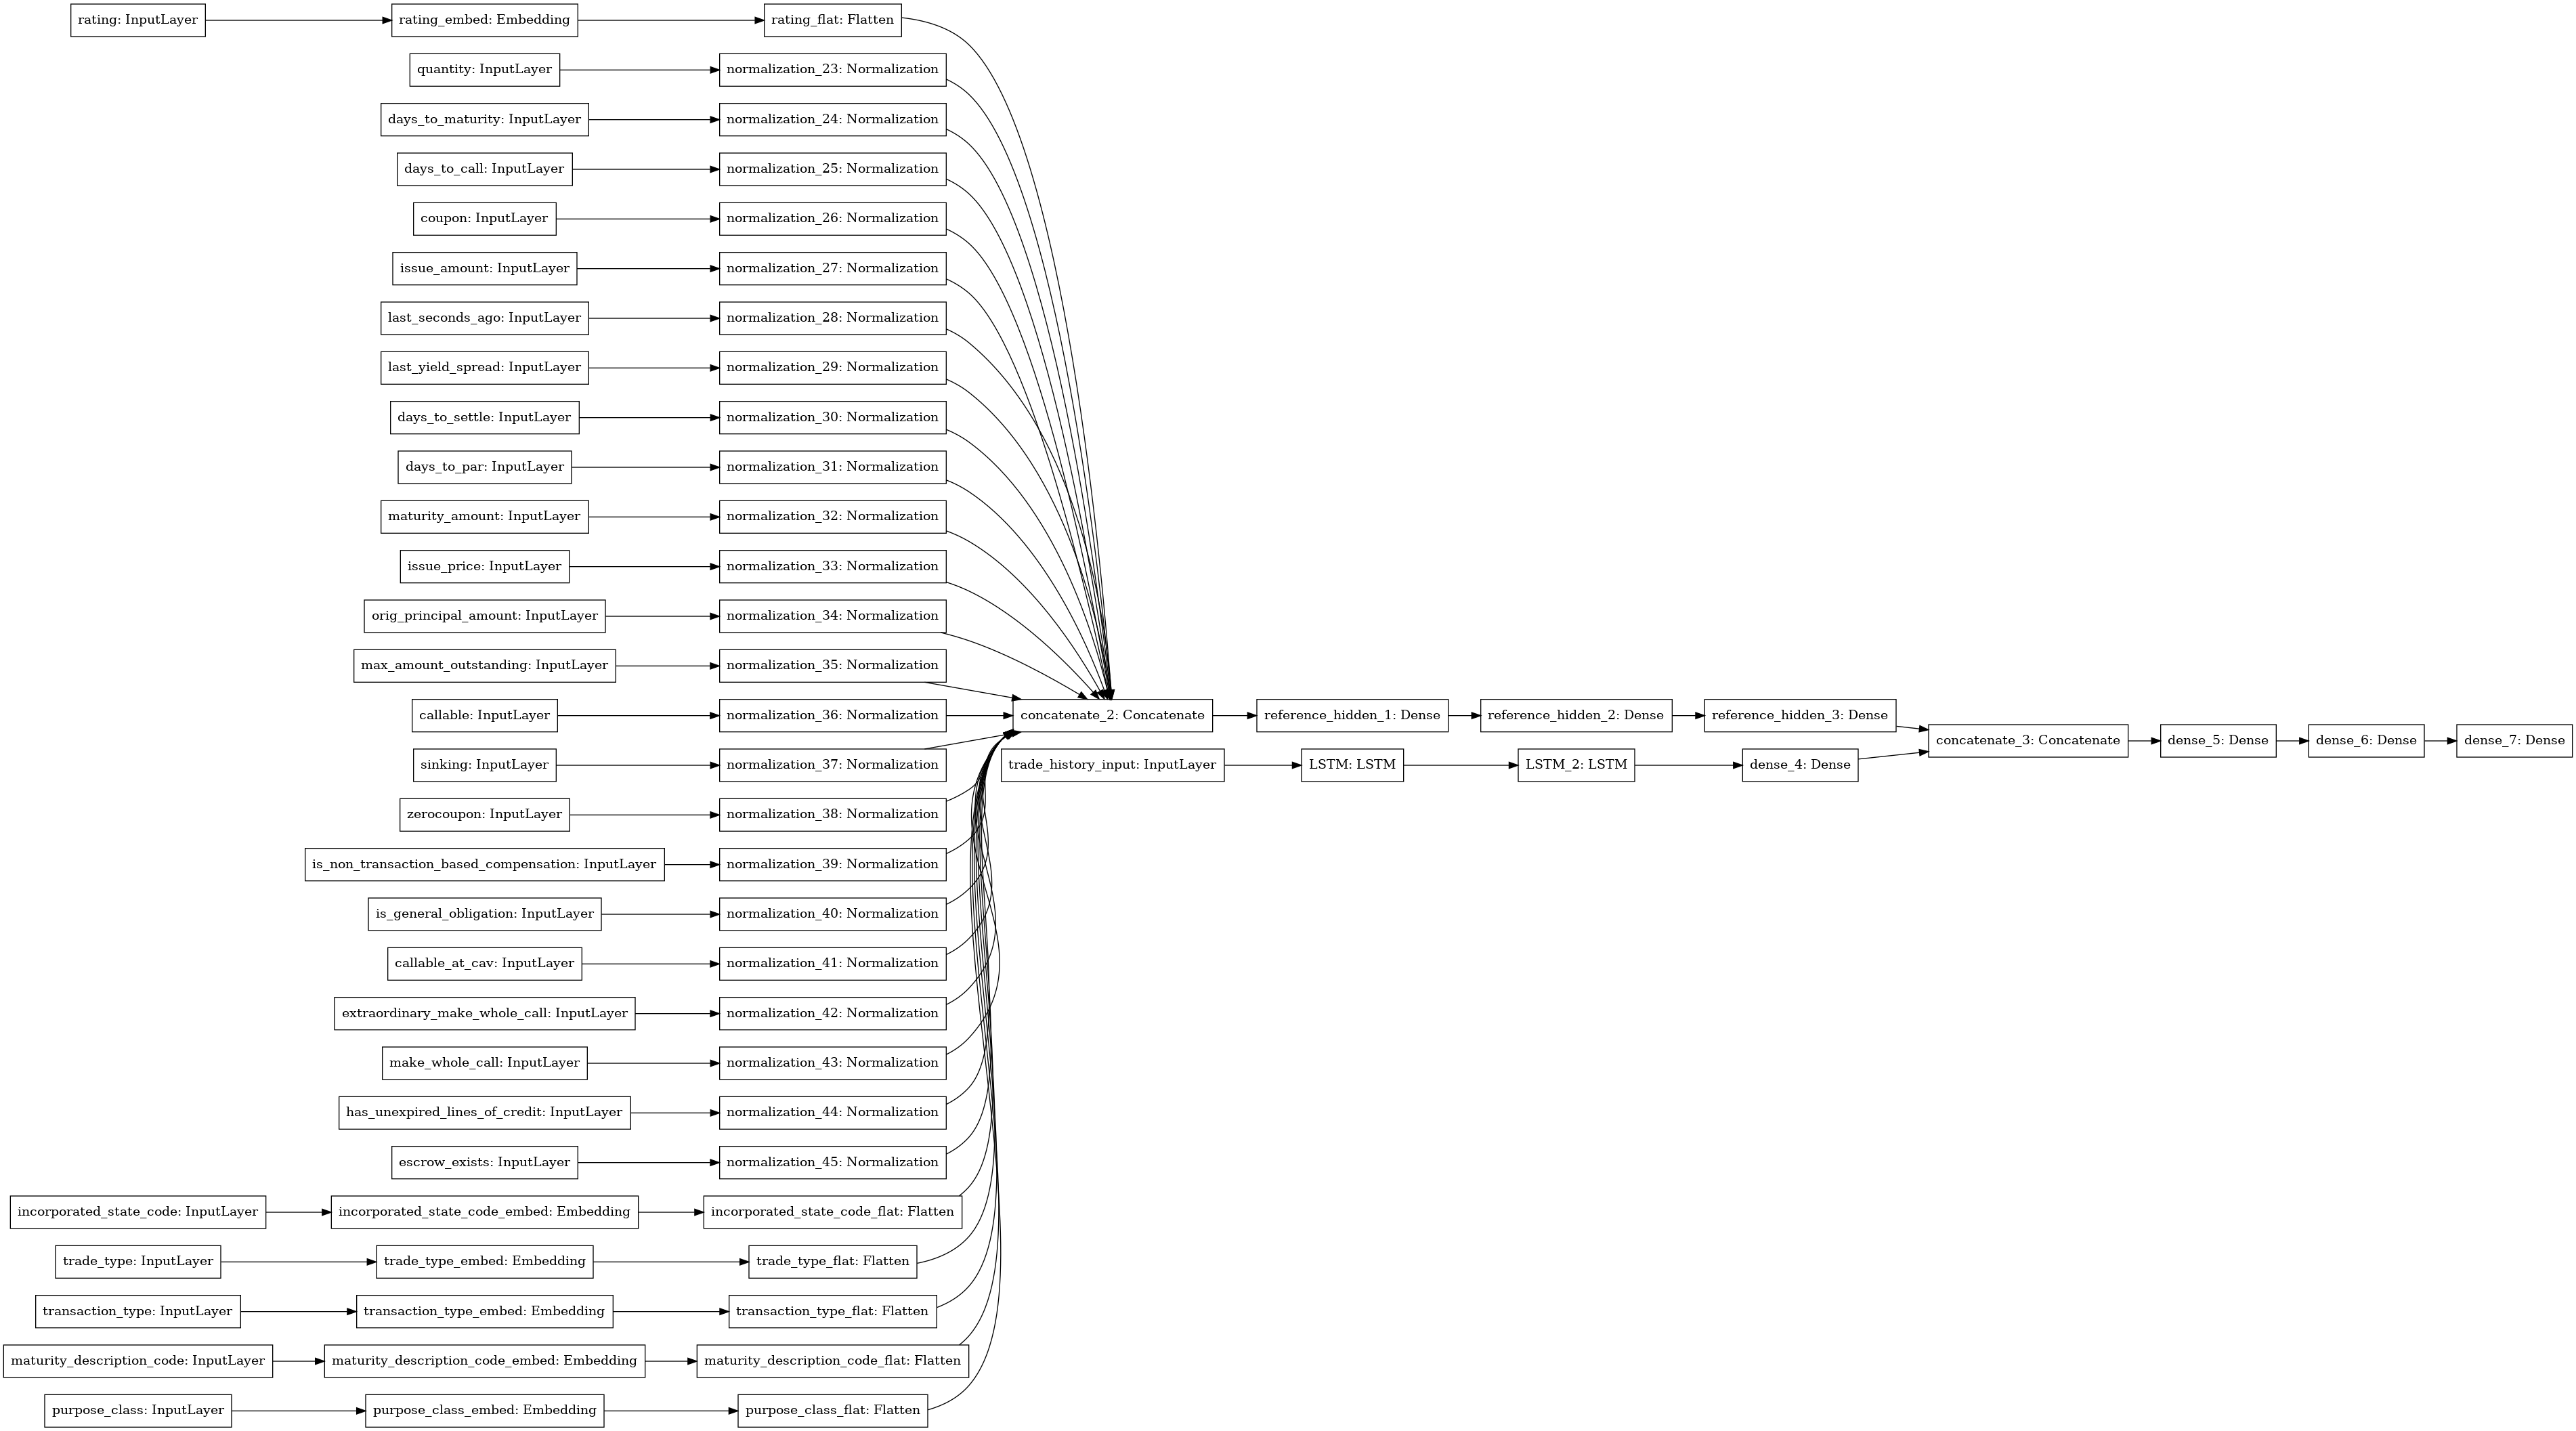

In [44]:
tf.keras.utils.plot_model(
    model,
    show_shapes=False,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=96,
)

In [45]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
          loss=keras.losses.MeanSquaredError(),
          metrics=[keras.metrics.MeanAbsoluteError()])

In [46]:
train_data = create_input(train_dataframe)
%time history = model.fit(x_train, y_train, epochs=50, batch_size=BATCH_SIZE, verbose=1, validation_split=0.1)

Epoch 1/50



User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   OMP_NUM_THREADS=40

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=160
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRI

408/408 [==============================] - 168s 394ms/step - loss: 1321.7173 - mean_absolute_error: 24.9994 - val_loss: 902.4701 - val_mean_absolute_error: 20.2984
Epoch 2/50
408/408 [==============================] - 159s 389ms/step - loss: 736.8226 - mean_absolute_error: 17.3862 - val_loss: 613.9373 - val_mean_absolute_error: 16.0209
Epoch 3/50
408/408 [==============================] - 158s 387ms/step - loss: 541.8746 - mean_absolute_error: 14.5753 - val_loss: 486.3233 - val_mean_absolute_error: 13.9652
Epoch 4/50
408/408 [==============================] - 157s 386ms/step - loss: 454.3362 - mean_absolute_error: 13.2548 - val_loss: 435.9129 - val_mean_absolute_error: 13.0921
Epoch 5/50
408/408 [==============================] - 158s 388ms/step - loss: 402.5915 - mean_absolute_error: 12.4245 - val_loss: 391.0868 - val_mean_absolute_error: 12.3726
Epoch 6/50
408/408 [==============================] - 159s 389ms/step - loss: 370.7226 - mean_absolute_error: 11.8937 - val_loss: 413.3209 -

In [47]:
%%time
_, mae = model.evaluate(x_val, y_val, verbose=1)
print(f"Test MAE: {round(mae, 3)}")

2495/2495 [==============================] - 43s 17ms/step - loss: 167.8658 - mean_absolute_error: 8.3530
Test MAE: 8.353
CPU times: user 3min 9s, sys: 1min, total: 4min 10s
Wall time: 43.3 s


In [48]:
model.save('saved_models/yield_spread_model')

INFO:tensorflow:Assets written to: saved_models/yield_spread_model/assets


INFO:tensorflow:Assets written to: saved_models/yield_spread_model/assets


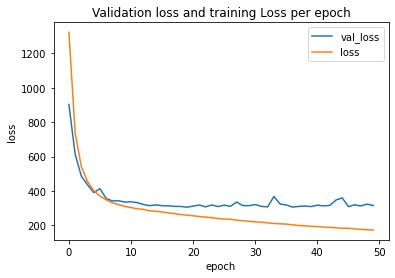

In [49]:
plt.plot(range(len(history.history['val_loss'])),history.history['val_loss'], label='val_loss')
plt.plot(range(len(history.history['loss'])),history.history['loss'], label='loss')
plt.title('Validation loss and training Loss per epoch')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [50]:
encarray = create_input(train_dataframe)
%time preds = model.predict(encarray)
preds = preds.reshape(len(preds))

error = train_dataframe.yield_spread - preds

CPU times: user 17min 52s, sys: 5min 47s, total: 23min 40s
Wall time: 3min 53s


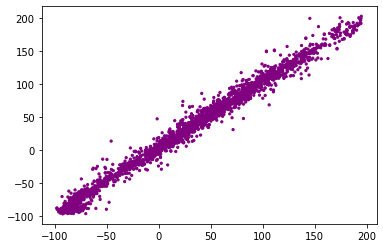

In [51]:
from matplotlib.colors import to_rgb, to_rgba
threshold = 1e6

# plot points with transparency depending on size of trade
def drawpoints(preds, target, train_dataframe):
    #Only draw Dealer-Dealer trades
    r, g, b = to_rgb('purple')
    keep = (10**train_dataframe.quantity > threshold) & (train_dataframe.trade_type == 'D')  # save time by not plotting points that would be invisible
    w = np.minimum( np.array(10**train_dataframe.quantity[keep]), threshold)
    opacity = w/threshold
    color = [(r, g, b, alpha) for alpha in opacity]
    plt.scatter(preds[keep], target[keep], s=5, c=color)
    
plt.figure()
drawpoints(preds, train_dataframe.yield_spread, train_dataframe)

In [52]:
test_preds = model.predict(create_input(val_dataframe))

In [53]:
evaluation_dataframe = val_dataframe.copy()
evaluation_dataframe['predicted_yield_spreads'] = test_preds
evaluation_dataframe['delta_yield_spreads'] = evaluation_dataframe.yield_spread - evaluation_dataframe.predicted_yield_spreads

In [54]:
evaluation_dataframe.days_to_maturity = 10**evaluation_dataframe.days_to_maturity
evaluation_dataframe.days_to_call = 10**evaluation_dataframe.days_to_call
evaluation_dataframe.quantity = 10**evaluation_dataframe.quantity
evaluation_dataframe.sort_values('delta_yield_spreads', ascending=False)

,rtrs_control_number,cusip,callable,sinking,zerocoupon,is_non_transaction_based_compensation,is_general_obligation,callable_at_cav,extraordinary_make_whole_call,make_whole_call,...,days_to_settle,days_to_par,maturity_amount,issue_price,orig_principal_amount,max_amount_outstanding,yield_spread,trade_history,predicted_yield_spreads,delta_yield_spreads
369361,2021082003191800,57582PB90,False,False,False,False,True,False,False,False,...,4,1.591065,7.681241,103.933621,7.681241,7.681241,181.549425,"[[-62.91735356585201, 4.301030158996582, 0.0, ...",-48.565014,230.114439
273576,2021090204896000,235036D56,False,False,False,False,False,False,False,False,...,5,1.748188,7.186674,114.684264,7.186674,7.186674,179.338511,"[[-43.26141472925799, 4.544067859649658, 1.0, ...",-50.091076,229.429587
301016,2021083004333600,786134TD8,False,False,False,False,False,False,False,False,...,2,1.963788,6.955207,113.785000,6.955207,6.955207,174.059671,"[[-74.13496432703501, 4.87506103515625, 0.0, 0...",-48.523403,222.583075
258847,2021090303130600,696560KY6,False,False,False,False,False,False,False,False,...,5,0.000000,7.616055,109.240000,7.616055,7.616055,173.142889,"[[-48.331435950302996, 4.602059841156006, 0.0,...",-36.144817,209.287706
287744,2021090101760200,64971XA32,True,False,False,False,False,False,False,False,...,2,2.181844,7.463818,115.376000,7.463818,7.463818,185.664414,"[[-65.75646318988998, 5.146128177642822, 1.0, ...",-22.710821,208.375235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368220,2021082002745200,64542CAP9,True,True,False,False,False,False,False,False,...,5,2.448706,6.492062,99.051065,6.492062,6.492062,28.749425,"[[140.58915719421898, 5.816241264343262, 1.0, ...",135.779449,-107.030024
269545,2021090201963800,64990FVW1,False,False,False,True,False,False,False,False,...,5,0.000000,7.993061,123.565000,7.993061,7.993061,-61.661489,"[[103.46441395571699, 4.20412015914917, 0.0, 0...",76.446747,-138.108236
320706,2021082600801400,88045RZH8,True,True,False,False,False,False,False,False,...,0,2.110590,7.265290,100.000000,7.265290,7.265290,-75.460314,"[[108.88348399131003, 4.176091194152832, 0.0, ...",96.361115,-171.821429
271073,2021090205521800,13063BMB5,False,False,False,False,True,False,False,False,...,5,0.000000,8.544068,101.560733,8.544068,8.544068,-81.661489,"[[269.838510803498, 5.301030158996582, 0.0, 0....",103.711639,-185.373129


In [55]:
evaluation_dataframe[evaluation_dataframe.last_yield_spread > 1000]

,rtrs_control_number,cusip,callable,sinking,zerocoupon,is_non_transaction_based_compensation,is_general_obligation,callable_at_cav,extraordinary_make_whole_call,make_whole_call,...,days_to_settle,days_to_par,maturity_amount,issue_price,orig_principal_amount,max_amount_outstanding,yield_spread,trade_history,predicted_yield_spreads,delta_yield_spreads
318958,2021082703218800,946813VJ8,False,False,False,False,True,False,False,False,...,4,2.716003,6.654177,96.885842,6.654177,6.654177,-49.484367,"[[2399.315633072284, 4.698969841003418, 0.0, 0...",-48.579773,-0.904594
341492,2021082403217900,432272FL1,False,False,True,False,True,False,False,False,...,2,0.000000,6.019117,54.907786,5.758745,6.019117,9.183484,"[[3924.8834839913093, 4.176091194152832, 1.0, ...",21.384302,-12.200818
347256,2021082404585000,938240DC9,False,False,False,False,False,False,False,False,...,2,0.000000,6.570543,123.261705,6.570543,6.570543,-55.716516,"[[1529.379070118896, 4.113943576812744, 1.0, 0...",-55.345833,-0.370683


In [56]:
temp = evaluation_dataframe[(evaluation_dataframe.delta_yield_spreads > 50) | (evaluation_dataframe.delta_yield_spreads < -50)  ]
temp = temp.sort_values('delta_yield_spreads',ascending=False)
display(temp)
temp.to_csv('greater_than_50.csv',index=False)

,rtrs_control_number,cusip,callable,sinking,zerocoupon,is_non_transaction_based_compensation,is_general_obligation,callable_at_cav,extraordinary_make_whole_call,make_whole_call,...,days_to_settle,days_to_par,maturity_amount,issue_price,orig_principal_amount,max_amount_outstanding,yield_spread,trade_history,predicted_yield_spreads,delta_yield_spreads
369361,2021082003191800,57582PB90,False,False,False,False,True,False,False,False,...,4,1.591065,7.681241,103.933621,7.681241,7.681241,181.549425,"[[-62.91735356585201, 4.301030158996582, 0.0, ...",-48.565014,230.114439
273576,2021090204896000,235036D56,False,False,False,False,False,False,False,False,...,5,1.748188,7.186674,114.684264,7.186674,7.186674,179.338511,"[[-43.26141472925799, 4.544067859649658, 1.0, ...",-50.091076,229.429587
301016,2021083004333600,786134TD8,False,False,False,False,False,False,False,False,...,2,1.963788,6.955207,113.785000,6.955207,6.955207,174.059671,"[[-74.13496432703501, 4.87506103515625, 0.0, 0...",-48.523403,222.583075
258847,2021090303130600,696560KY6,False,False,False,False,False,False,False,False,...,5,0.000000,7.616055,109.240000,7.616055,7.616055,173.142889,"[[-48.331435950302996, 4.602059841156006, 0.0,...",-36.144817,209.287706
287744,2021090101760200,64971XA32,True,False,False,False,False,False,False,False,...,2,2.181844,7.463818,115.376000,7.463818,7.463818,185.664414,"[[-65.75646318988998, 5.146128177642822, 1.0, ...",-22.710821,208.375235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368220,2021082002745200,64542CAP9,True,True,False,False,False,False,False,False,...,5,2.448706,6.492062,99.051065,6.492062,6.492062,28.749425,"[[140.58915719421898, 5.816241264343262, 1.0, ...",135.779449,-107.030024
269545,2021090201963800,64990FVW1,False,False,False,True,False,False,False,False,...,5,0.000000,7.993061,123.565000,7.993061,7.993061,-61.661489,"[[103.46441395571699, 4.20412015914917, 0.0, 0...",76.446747,-138.108236
320706,2021082600801400,88045RZH8,True,True,False,False,False,False,False,False,...,0,2.110590,7.265290,100.000000,7.265290,7.265290,-75.460314,"[[108.88348399131003, 4.176091194152832, 0.0, ...",96.361115,-171.821429
271073,2021090205521800,13063BMB5,False,False,False,False,True,False,False,False,...,5,0.000000,8.544068,101.560733,8.544068,8.544068,-81.661489,"[[269.838510803498, 5.301030158996582, 0.0, 0....",103.711639,-185.373129


In [57]:
temp = evaluation_dataframe[(evaluation_dataframe.delta_yield_spreads < 50) & (evaluation_dataframe.delta_yield_spreads > -50)  ]
temp.sort_values('delta_yield_spreads',ascending=False)
display(temp)
# temp.to_csv('less_than_3.csv',index=False)

,rtrs_control_number,cusip,callable,sinking,zerocoupon,is_non_transaction_based_compensation,is_general_obligation,callable_at_cav,extraordinary_make_whole_call,make_whole_call,...,days_to_settle,days_to_par,maturity_amount,issue_price,orig_principal_amount,max_amount_outstanding,yield_spread,trade_history,predicted_yield_spreads,delta_yield_spreads
253529,2021090702001700,180848XZ1,True,False,False,False,False,False,False,False,...,2,3.421768,7.248586,115.524816,7.248586,7.248586,18.290604,"[[11.359671429567996, 4.0, 0.0, 1.0, 5.8308919...",11.556490,6.734114
253530,2021090703604900,041042E24,False,False,False,False,True,False,False,False,...,2,0.000000,5.919079,125.698716,5.919079,5.919079,-37.009396,"[[-54.736782452647994, 4.176091194152832, 0.0,...",-42.272133,5.262737
253534,2021090703643200,798785CS8,True,True,False,False,False,False,False,False,...,2,2.622214,6.922466,100.000000,6.922466,6.922466,-47.609396,"[[-45.028199342742006, 4.176091194152832, 0.0,...",-29.289314,-18.320082
253535,2021090700175700,190335KL2,False,False,False,False,True,False,False,True,...,2,0.000000,6.881670,100.000000,6.881670,6.881670,35.390604,"[[39.14288908614398, 4.301030158996582, 1.0, 0...",31.136293,4.254311
253536,2021090700882900,761440H90,False,False,False,False,True,False,False,False,...,2,0.000000,5.518515,124.458000,5.518515,5.518515,-36.309396,"[[-28.190397303142, 4.176091194152832, 0.0, 0....",-29.444889,-6.864507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372550,2021082005028300,353838XL4,False,False,False,False,True,False,False,False,...,4,0.000000,5.961422,117.296734,5.961422,5.961422,-71.850575,"[[-70.13347470302, 4.544067859649658, 0.0, 1.0...",-71.481781,-0.368794
372551,2021082004293800,1663937M4,False,False,False,True,True,False,False,False,...,4,0.000000,6.410777,120.255388,6.410777,6.410777,-50.750575,"[[-65.80492226865799, 4.698969841003418, 1.0, ...",-66.553871,15.803296
372553,2021082000565900,501552GC1,True,False,False,False,True,False,False,False,...,4,2.858537,5.880814,99.534488,5.880814,5.880814,-6.250575,"[[1.1654366572179997, 4.0, 0.0, 1.0, 7.7161625...",-13.286577,7.036002
372556,2021082004032200,469487KJ0,False,False,False,False,False,False,False,False,...,4,0.000000,6.729974,123.238889,6.729974,6.729974,-77.150575,"[[-71.43130352333, 5.0, 1.0, 0.0, 5.2523189329...",-81.588379,4.437804


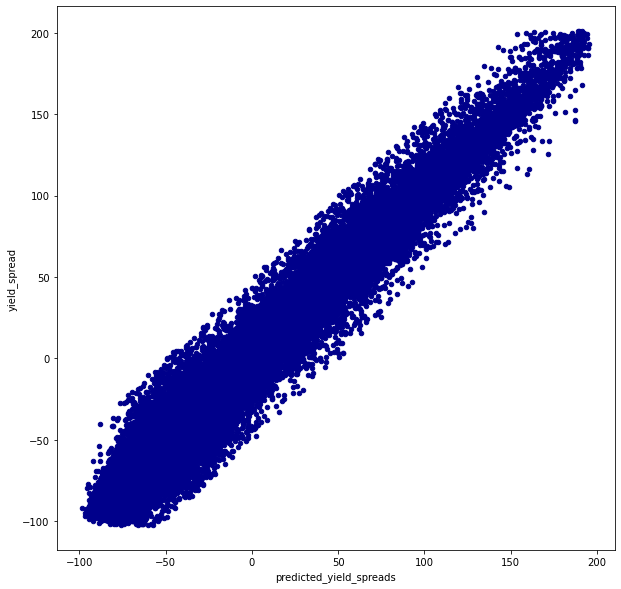

In [59]:
ax = evaluation_dataframe.plot.scatter(x='predicted_yield_spreads', y='yield_spread', c='DarkBlue', figsize=(10,10))

In [97]:
ax.get_figure().savefig('ficc ys vs yield spread')

In [99]:
rtrs = evaluation_dataframe[(evaluation_dataframe.delta_yield_spreads > 50) | (evaluation_dataframe.delta_yield_spreads < -50)]['rtrs_control_number']  

In [100]:
greater_than_50 = temp[temp.rtrs_control_number.isin(rtrs.values)]

In [101]:
temp.predicted_yield_spreads

253130    112.558945
253131      2.177818
253134     69.279060
253135    -21.818380
253136     47.714886
             ...    
372128     -9.936625
372129    -43.582603
372130    -60.091988
372133     98.801231
372134     82.937332
Name: predicted_yield_spreads, Length: 78114, dtype: float32

In [102]:
greater_than_50['predicted_yield_spreads'] = temp['predicted_yield_spreads']

In [103]:
greater_than_50.to_csv('greater_than_50.csv')